In [1]:
import pandas as pd
import os
import pickle

In [2]:
file_path = '../Sup/genres.csv'
dataset = pd.read_csv(file_path)

dataset.head()

,review,genre,sentiment
0,Confidently directed dark brooding and pack...,Action,Positive
1,Nolans have given the character this great man...,Action,Positive
2,there is action explosions and stunt work but...,Action,Positive
3,The acting story atmosphere and actions scenes...,Action,Positive
4,I recommend it to anyone who likes action movi...,Action,Positive


In [4]:
data = dataset.review
data.head()

0    Confidently directed  dark  brooding  and pack...
1    Nolans have given the character this great man...
2    there is action  explosions and stunt work but...
3    The acting story atmosphere and actions scenes...
4    I recommend it to anyone who likes action movi...
Name: review, dtype: object

In [5]:
label_cat = dataset.genre
#label_cat.unique()

array(['Action', 'Horror', 'Comedy', 'Romance', 'Animation'], dtype=object)

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
data = data.str.lower()
aspect_terms = []
for review in nlp.pipe(data):
    chunks = [chunk.root.text for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset[3] = aspect_terms

In [8]:
dataset.head()

,review,genre,sentiment,3
0,Confidently directed dark brooding and pack...,Action,Positive,sequences story
1,Nolans have given the character this great man...,Action,Positive,character manifesto actions
2,there is action explosions and stunt work but...,Action,Positive,work dialogue
3,The acting story atmosphere and actions scenes...,Action,Positive,atmosphere scenes
4,I recommend it to anyone who likes action movi...,Action,Positive,movies


In [10]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size,oov_token="<OOV>")
tokenizer.fit_on_texts(dataset[3])
sequence = tokenizer.texts_to_sequences(dataset[3])
#aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(dataset[3]))
aspect_tokenized = pad_sequences(sequence,maxlen=120,padding='post',truncating='post',value=0)

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(label_cat)
dummy_category = to_categorical(integer_category)

In [12]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,10,input_length=120),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 10)           60000     
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7206      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 35        
Total params: 67,241
Trainable params: 67,241
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(aspect_tokenized, dummy_category, epochs=20, verbose=1)

Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 824us/sample - loss: 1.6100 - accuracy: 0.1780
Epoch 2/20
1000/1000 [==============================] - 0s 96us/sample - loss: 1.6078 - accuracy: 0.2160
Epoch 3/20
1000/1000 [==============================] - 0s 97us/sample - loss: 1.5991 - accuracy: 0.3140
Epoch 4/20
1000/1000 [==============================] - 0s 98us/sample - loss: 1.5827 - accuracy: 0.3470

In [14]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

0 999
6 995
Train on 999 samples, validate on 989 samples
Epoch 1/5
999/999 [==============================] - 0s 264us/sample - loss: 0.7290 - accuracy: 0.7568 - val_loss: 0.7206 - val_accuracy: 0.7776
Epoch 2/5
999/999 [==============================] - 0s 172us/sample - loss: 0.7098 - accuracy: 0.7758 - val_loss: 0.7015 - val_accuracy: 0.7745
Epoch 3/5
999/999 [==============================] - 0s 171us/sample - loss: 0.6935 - accuracy: 0.8068 - val_loss: 0.6859 - val_accuracy: 0.7806
Epoch 4/5
999/999 [==============================] - 0s 169us/sample - loss: 0.6763 - accuracy: 0.7758 - val_loss: 0.6698 - val_accuracy: 0.8129

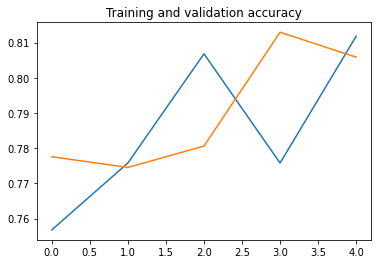

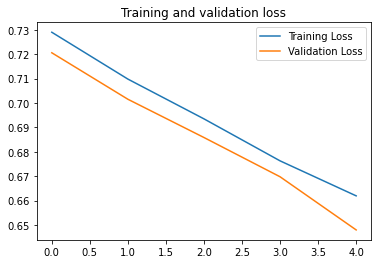

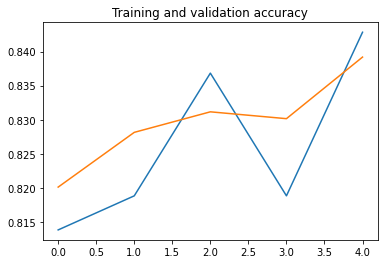

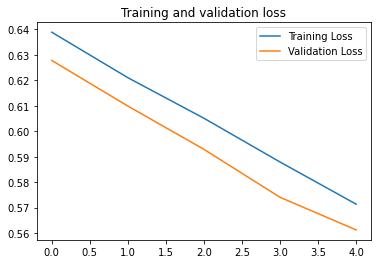

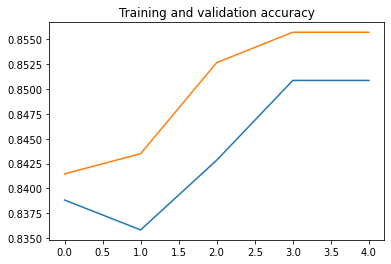

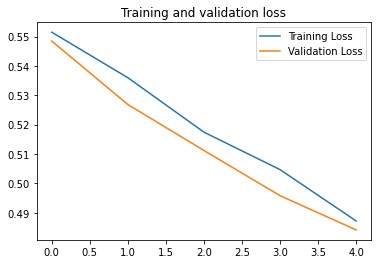

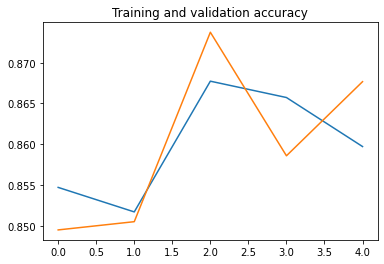

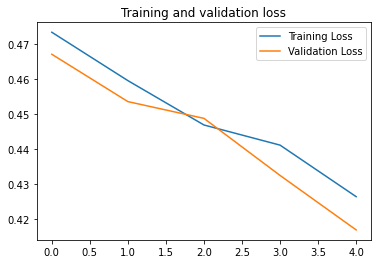

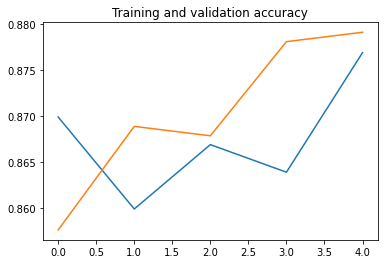

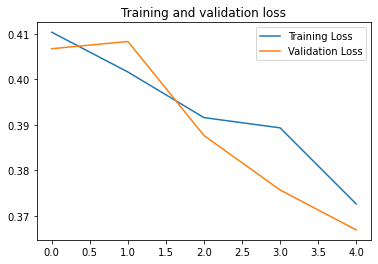

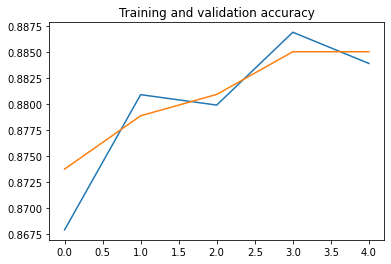

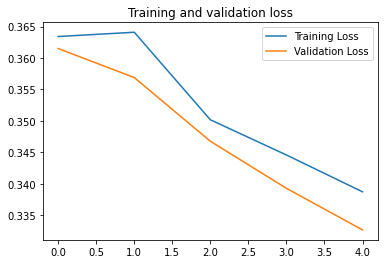

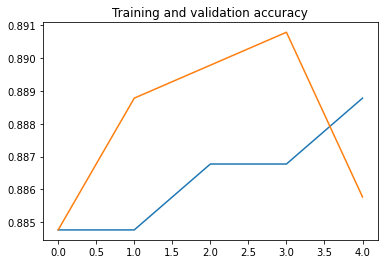

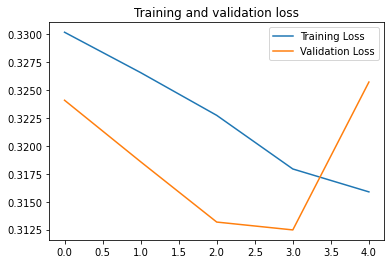

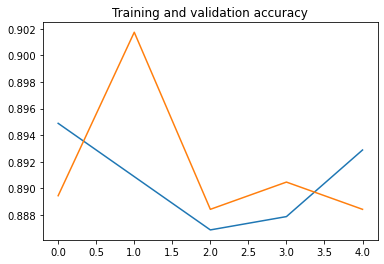

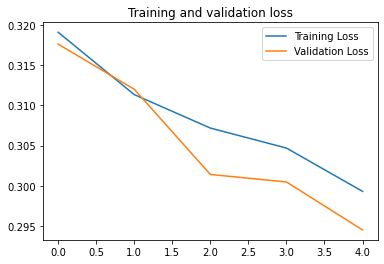

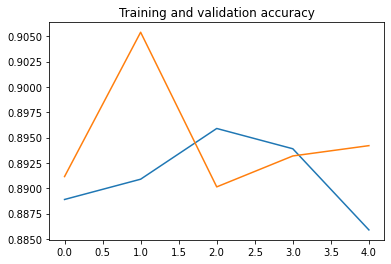

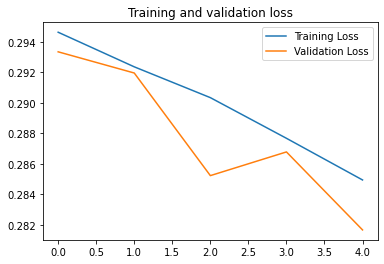

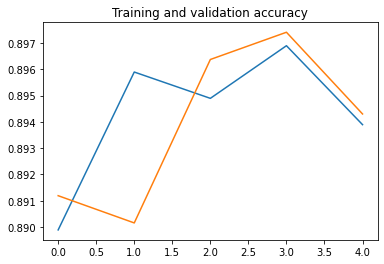

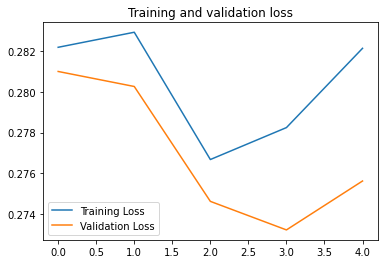

In [17]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokenized[train_start:train_end,:],\
                                       aspect_tokenized[test_start:test_end,:], \
                                       dummy_category[train_start:train_end,:], \
                                       dummy_category[test_start:test_end,:]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [18]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/categorical_genre_model.h5')
model.save_weights( "../Sup/categorical_genre_model_weights.h5")

In [19]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/categorical_genre_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('../Sup/categorical_genre_labeleEncorder.pkl', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)